## Optional programming exercises

## Part 1
Implement the Hough transform to detect circles.

$$
\begin{align}
(x-X_0)^2 + (y-Y_0)^2 = r^2 \\
\end{align}
$$

In principle, $X_0$ and $Y_0$ can be outside the image plane.  In addition, there is no upper limit on $r$.

For starters, we will confine ourselves to image coordinates.  Also, we will inspect the image and use only reasonable values for $r$.

In [29]:
from __future__ import division, print_function

import numpy as np
from matplotlib import pyplot as plt
import time
import sys

import skimage
from skimage import img_as_float, img_as_ubyte
from skimage import io
from skimage.color import rgb2gray
from skimage.util import random_noise
from skimage import transform

%matplotlib inline

In [30]:
def plot_1xc(imgs_list, titles_list, save_file=None):
    cols = len(imgs_list)
    i = 0
    
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,15))
    for c in range(cols):
        axes[c].imshow(imgs_list[i], cmap="gray")
        axes[c].set_title(titles_list[i], size=20)
        axes[c].set_xticks([])
        axes[c].set_yticks([])
        i = i + 1
    plt.tight_layout();
    
    if not (save_file == None):
        filename = time.strftime("%Y%m%d_%H%M") + "_" + save_file + ".png"
        fig.savefig(filename, bbox_inches='tight')
        

In [31]:
def build_accumulator(edges, radii, prob):
    """Builds Hough circle accumulator.  
    'edges' is the edge-detected image.  
    'radii' are the candidate circle radii.  
    'prob' is the proportion of edge pixels to process."""
    rads = radii.shape[0]
    rows = edges.shape[0]
    cols = edges.shape[1]
    
    A = np.zeros((rads, rows, cols))
    
    xi = np.arange(rows)
    yi = np.arange(cols)
    X = np.tile(xi,(cols,1)).transpose()
    Y = np.tile(yi,(rows,1))

    for x in range(rows):
        if (x % 50) == 0:
            sys.stdout.write(str(x)+", ") 
        for y in range(cols):
            if (edges[x,y] != 0) & (np.random.rand() < prob):
                R = np.sqrt((X-x)**2 + (Y-y)**2)
                for i in range(rads):
                    if i == rads - 1:
                        mask = R > radii[i]
                    else:
                        mask = (R > radii[i]) & (R <= radii[i+1])
                    A[i][mask] += 1
                        
    return A

In [32]:
from skimage import feature

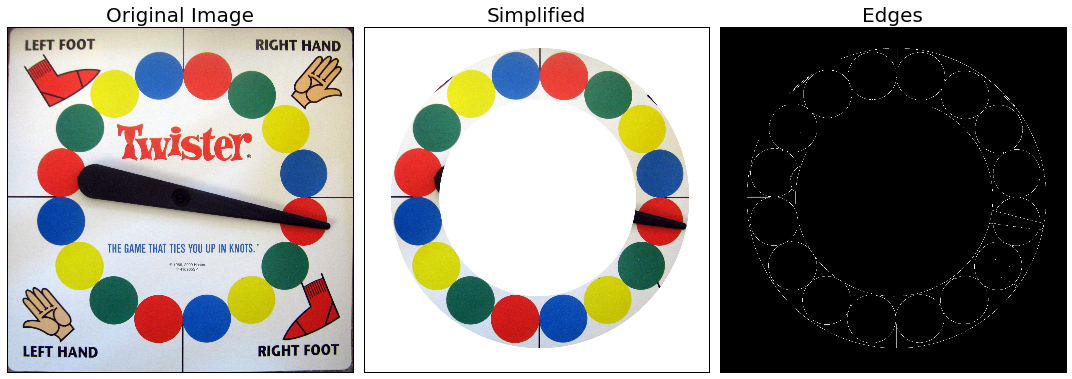

In [33]:
O = io.imread("../images/twister.jpg")
OS = io.imread("../images/twister_simplified.jpg")
I = rgb2gray(OS)
I = feature.canny(I)
plot_1xc([O,OS,I], ["Original Image", "Simplified", "Edges"], save_file="original")

In [34]:
# Diameters in image: 220, 910, 1384. Radii: 110, 455, 692.
radii = np.array([100, 120, 445, 465, 682, 702])

In [35]:
A = build_accumulator(I, radii, 0.2)

0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 

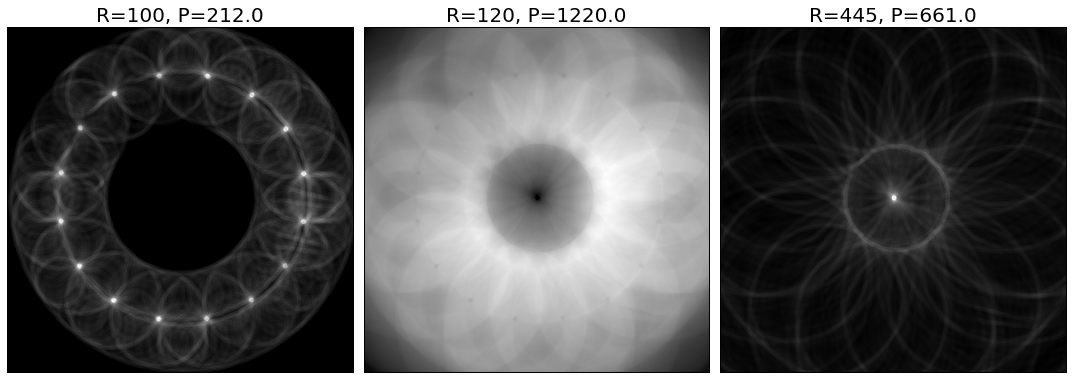

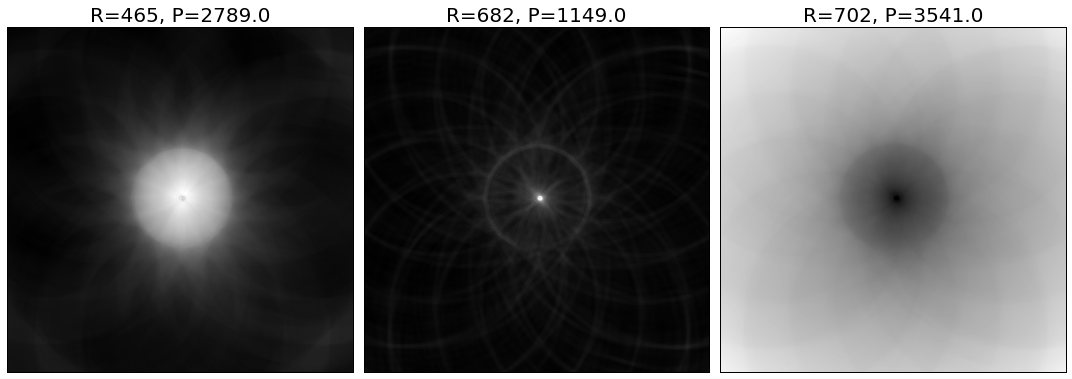

In [36]:
peak_vals = np.max(np.max(A, axis=2), axis=1)
for i in range(0,radii.shape[0],3):
    ims = [A[i], A[i+1], A[i+2]]
    titles = ["R=" + str(radii[i]) + ", " + "P=" + str(peak_vals[i]), 
              "R=" + str(radii[i+1]) + ", " + "P=" + str(peak_vals[i+1]), 
              "R=" + str(radii[i+2]) + ", " + "P=" + str(peak_vals[i+2])]
    plot_1xc(ims, titles, save_file="hough"+str(i))


In [37]:
def find_hotspots(img, n_hotspots, neighborhood_size):
    """Returns the image coordinates of the hot spots in the image, 'img'.
    'n_hotspots' is the number of hot spots to return.
    'neighborhood_size' is the area around each hot spot to ignore after detection."""
    img2 = img.copy()
    x = []
    y = []
    offset = np.floor(neighborhood_size/2.0).astype(int)
    for i in range(n_hotspots):
        xy = np.where(img2 == np.max(img2))
        xi = xy[0][0]
        yi = xy[1][0]
        x.append(xi)
        y.append(yi)
        
        img2[(xi-offset):(xi+offset+1), (yi-offset):(yi+offset+1)] = 0
    return x,y

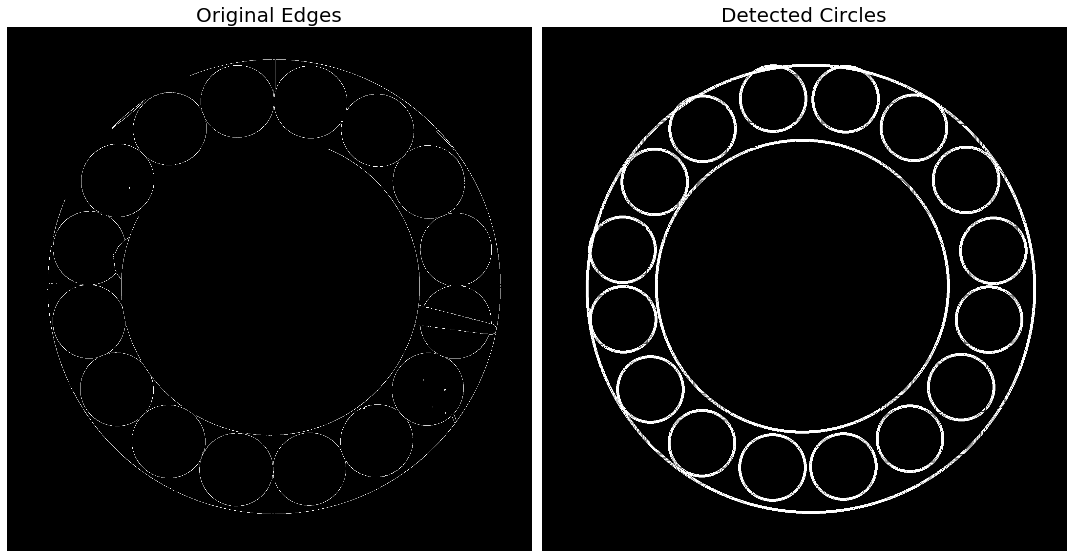

In [38]:
from skimage.draw import circle_perimeter

I2 = np.zeros_like(I)

for n in [0,2,4]:
    r = radii[n]
    if n == 0:
        n_circles = 16
    else:
        n_circles = 1

    x,y = find_hotspots(A[n], n_circles, 41)
    # print(x,y)

    for i in range(len(x)):
        for ri in range(r-4,r+5):
            rr, cc = circle_perimeter(x[i], y[i], ri)
            I2[rr,cc] = 255

plot_1xc([I,I2],["Original Edges", "Detected Circles"], save_file="detected")